# K-Nearest Neighbors (and PCA)

but first...

## Principle Component Analysis (PCA)

Principle Component Analysis (PCA) is an algorithm for dimensionality reduction. When we have a feature vector describing a data point, we can think of each feature being an orthogonal (perpendicular) axis on a plot. 

PCA computes new axes as a linear combination of the existing axes and re-orients (or projects) the data onto these new axes.

 - These new axes are called Principle Components (PC)
 - They are also a set of orthogonal axes.
 - The first PC is in the direction in which the data varies most. 
  - The second PC is perpendicular to the first and points in the direction the data varies second-most. 
  - The third PC is perpendicular to the first 2 and points in the direction the data varies third-most.
 - The PCs are ordered by importance. Their importance is quantified by a Singular Value.

Because the PCs are ordered by their explanatory power, we can keep just a few and discard the less informative features.

Let's look at an example.

### Example

Lets revisit the Palmer's Penguins dataset. Suppose we only had measurements of the bill to work with (length and depth).

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


In [2]:
palmers = pd.read_csv('https://gist.githubusercontent.com/slopp/ce3b90b9168f2f921784de84fa445651/raw/4ecf3041f0ed4913e7c230758733948bc561f434/penguins.csv', index_col = 'rowid')
palmers.dropna(axis = 0, inplace=True)
palmers

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
rowid,,,,,,,,
1,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
2,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
3,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
5,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
6,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007
...,...,...,...,...,...,...,...,...
340,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
341,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
342,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009


In [3]:
features_to_use = ['bill_length_mm', 'bill_depth_mm']
target = ['species']

X = palmers[features_to_use]
y = palmers[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

# We'll need this later when plotting the pca
Xs = ss.transform(X)

labEnc = LabelEncoder()
z_train = labEnc.fit_transform(y_train)
z_test = labEnc.transform(y_test)
label_names = labEnc.classes_


/Users/eatai/.pyenv/versions/3.13.1/envs/datascience/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/eatai/.pyenv/versions/3.13.1/envs/datascience/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Now let's apply PCA to our feature data.

In [4]:
pca = PCA(n_components=2, svd_solver='full')
P_train = pca.fit_transform(Xs_train)
P_test = pca.transform(Xs_test)
P = pca.transform(Xs)

pca_cols = pca.get_feature_names_out()
palmers_PCA = pd.DataFrame(data = P, columns = pca_cols)
palmers_PCA['species'] = y

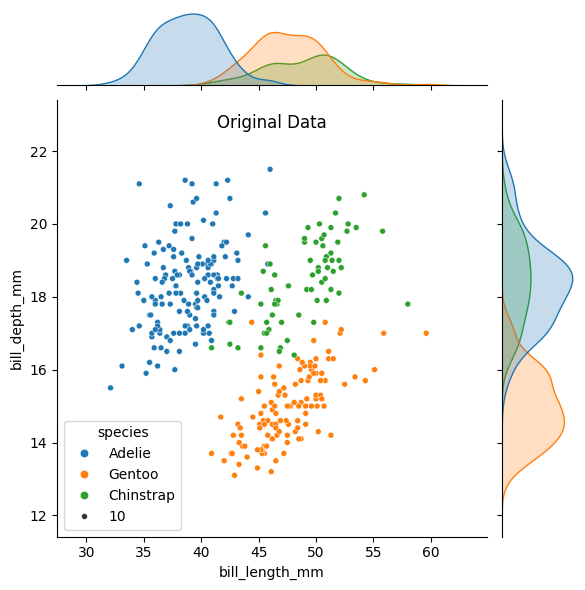

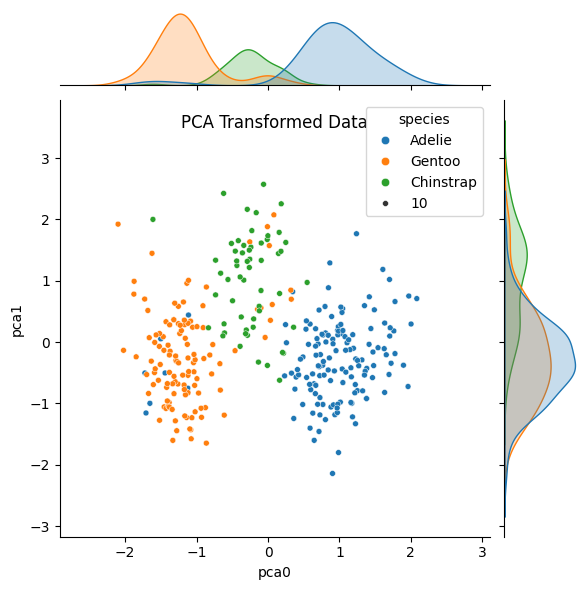

In [5]:
sns.jointplot(data = palmers, x = 'bill_length_mm', y = 'bill_depth_mm', hue = 'species', size = 10)
plt.title('Original Data', y = 1.0, pad = -20)
plt.show()

sns.jointplot(data = palmers_PCA, x = 'pca0', y='pca1', hue = 'species', palette = 'tab10', size = 10)
plt.title('PCA Transformed Data', y = 1.0, pad = -20)
plt.show()

And we'll use a decision tree to model.

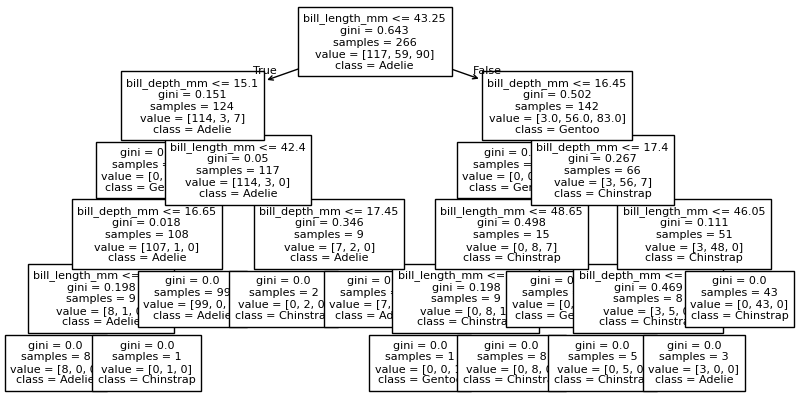

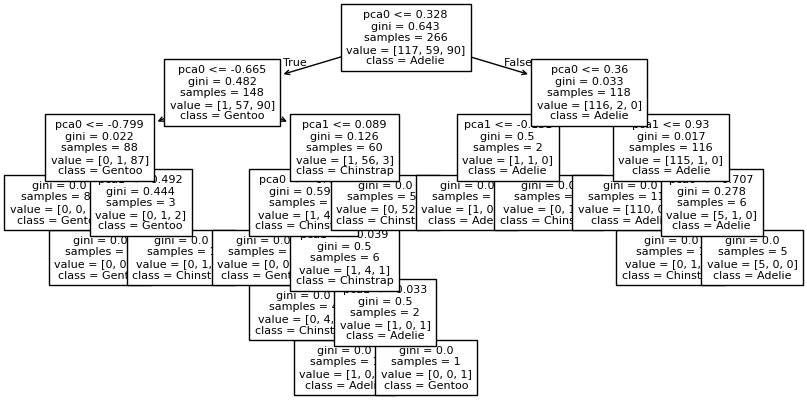

In [14]:
tree_depth = 10

# Fitting the model on Original Data
tree_clf = DecisionTreeClassifier(max_depth = tree_depth)
tree_clf.fit(X_train, y_train)

fig, ax = plt.subplots(1,1, figsize = (10, 5))
plot_tree(tree_clf,
          fontsize = 8,
          feature_names=features_to_use,
          class_names = label_names,
          filled = False)
plt.show()


# Fitting the model on PCA-transformed data
tree_clf2 = DecisionTreeClassifier(max_depth = tree_depth)
tree_clf2.fit(P_train, y_train)

fig, ax = plt.subplots(1,1, figsize = (10, 5))
plot_tree(tree_clf2,
          fontsize = 8,
          feature_names=pca_cols,
          class_names = label_names,
          filled = False)
plt.show()

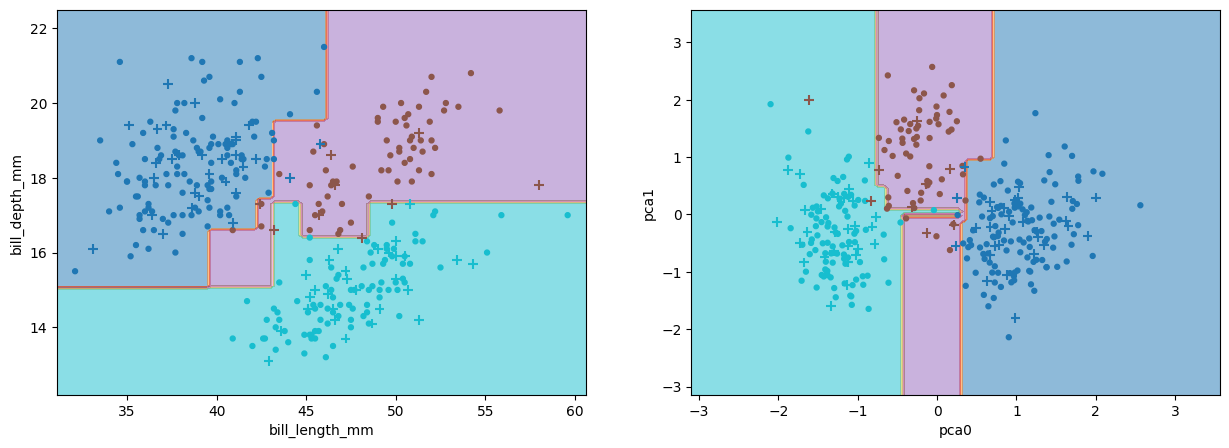

In [15]:
cmap = 'tab10'
fig, ax = plt.subplots(1,2, figsize = (15,5))

tree_boundaries = DecisionBoundaryDisplay.from_estimator(tree_clf, X=X_train,
                                                         xlabel = 'bill_length_mm',
                                                         ylabel = 'bill_depth_mm',
                                                         response_method = 'predict',
                                                         cmap = cmap, alpha = 0.5,
                                                         ax=ax[0])

ax[0].scatter(X_train['bill_length_mm'], X_train['bill_depth_mm'], 
            c = z_train, cmap=cmap,
            marker = '.', s = 50, label = label_names)
ax[0].scatter(X_test['bill_length_mm'], X_test['bill_depth_mm'], 
            c = z_test, cmap = cmap,
            marker = '+', s=50)


tree_boundaries2 = DecisionBoundaryDisplay.from_estimator(tree_clf2, X=P_train,
                                                         xlabel = 'pca0',
                                                         ylabel = 'pca1',
                                                         response_method = 'predict',
                                                         cmap = cmap, alpha = 0.5,
                                                         ax=ax[1])

ax[1].scatter(P_train[:,0], P_train[:,1], 
            c = z_train, cmap=cmap,
            marker = '.', s = 50, label = label_names)
ax[1].scatter(P_test[:,0], P_test[:,1], 
            c = z_test, cmap = cmap,
            marker = '+', s=50)

plt.show()



/Users/eatai/.pyenv/versions/3.13.1/envs/datascience/lib/python3.13/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


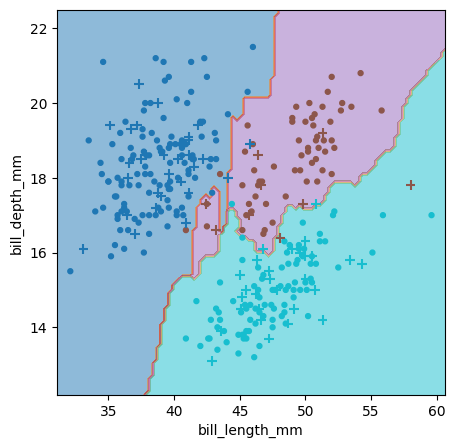

In [25]:
from sklearn.neighbors import KNeighborsClassifier

fig, ax = plt.subplots(1,1, figsize = (5,5))

knn = KNeighborsClassifier(n_neighbors = 3)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

knn_boundaries = DecisionBoundaryDisplay.from_estimator(knn, X=X_train,
                                                         xlabel = 'bill_length_mm',
                                                         ylabel = 'bill_depth_mm',
                                                         response_method = 'predict',
                                                         cmap = cmap, alpha = 0.5,
                                                         ax=ax)

ax.scatter(X_train['bill_length_mm'], X_train['bill_depth_mm'], 
            c = z_train, cmap=cmap,
            marker = '.', s = 50, label = label_names)
ax.scatter(X_test['bill_length_mm'], X_test['bill_depth_mm'], 
            c = z_test, cmap = cmap,
            marker = '+', s=50)

plt.show()


## K-Nearest Neighbors (KNN) (a lazy learner)

A K-Nearest Neighbors classifier doesn't really learn a model at all. Instead, to determine the label for an unknown sample, it finds the K data points from the training set closest to the unlabeled sample (the K nearest neighbors) and assigns the majority label among the nearest neighbors.

<img src="knn_cartoon.png" style = "width: 40vw" alt="image credit: JC Chouinard" />
image credit: JC Chouinard

### Eager vs Lazy models

 - *Eager learners* spend more time and resources training a *simple* model that generalizes and prediction is quick and not computationally intensive (simple, quick, and computationally intensive are all relative).

 - *Lazy learners* store data and do most of the computation at the time of prediction. Lazy learners are slower to predict, but they are also adaptable to new data because the training overhead is low.

 **KNN is a very lazy learner!**

### Hyper parameters of KNN

<a href = "https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html"> sklearn.neighbors.KNeighborsClassifier </a>


 - ```n_neighbors``` - number of neighbors (why not k?! come on sklearn devs!). **Rule of thumb, start with square root of number of samples.**

    - If k is too small, the model will be too specific and won't generalize well to new data. The classifier will fit the training data well, but fail to generalize to the test set. This is called *overfitting*. 

    - If k is too large, the model will fail to predict correct labels in the training set. This is called *underfitting*.


 - ```metric``` - the metric is how distance is calculated between samples. Two common metrics to use:

    - Euclidean distance - "euclidean" - $d(p,q) = \sqrt{(p_1-q_1)^2 + (p_2-q_2)^2 + \cdots + (p_m-q_m)^2 }$ 
    
    - Manhattan distance - "manhattan" - $d(p,q) = |p_1-q_1| + |p_2-q_2| + \cdots + |p_m-q_m|^2$


### Example: MNIST

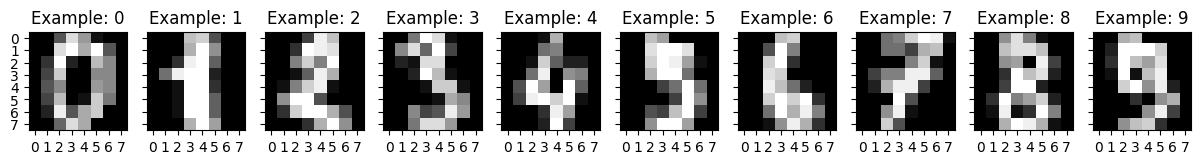

In [30]:
from sklearn.datasets import load_digits

digits = load_digits()

fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15, 3), sharey=True)

for ax, image, label in zip(axes, digits['images'], digits['target']):
    ax.set_xticks(range(0,8))
    ax.set_yticks(range(0,8))

    ax.imshow(image, cmap=plt.cm.gist_gray, interpolation="nearest")
    ax.set_title(f'Example: {label}')

In [31]:
def unfurl_imageset(image_set):
    if len(image_set.shape)==2:
        num_images = 1
    else:
        num_images = len(image_set)
    return image_set.reshape((num_images, -1))

def refurl_imageset(vector_set, image_size):
    if len(vector_set.shape)==1:
        return vector_set.reshape((image_size[0], image_size[1]))    
    else:
        num_vectors = len(vector_set)
        return vector_set.reshape((num_vectors, image_size[0], image_size[1]))

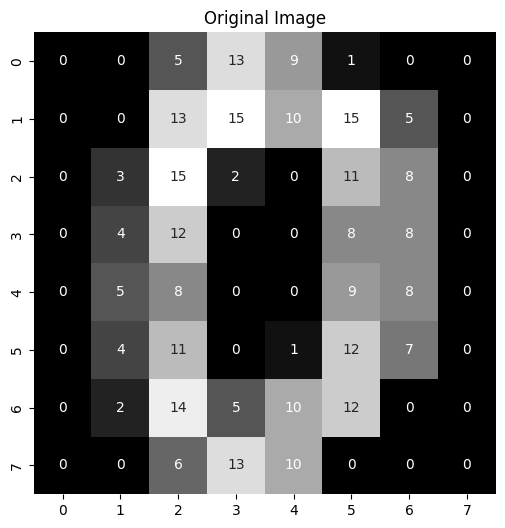

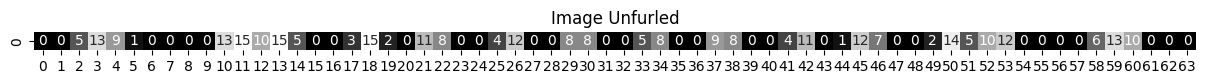

In [32]:

vector_0 = unfurl_imageset(digits['images'][0])

fig, ax0 = plt.subplots(1,1, figsize = (6, 6))
image_cmap = plt.cm.gist_gray

sns.heatmap(digits['images'][0], annot = True,
            cmap=image_cmap, cbar = False,
            ax = ax0)
ax0.set_aspect('equal')
ax0.set_title('Original Image')

fig, ax1 = plt.subplots(1,1, figsize = (15, 5))
sns.heatmap(vector_0, annot = True,
            cmap=image_cmap, cbar = False,
            ax = ax1)
ax1.set_aspect('equal')
ax1.set_title('Image Unfurled')
plt.show()


In [33]:
X = unfurl_imageset(digits['images'])
y = digits['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

pca = PCA(n_components = 64)
P_train = pca.fit_transform(X_train)
P_test = pca.transform(X_test)


In [34]:
pca.__dict__

{'n_components': 64,
 'copy': True,
 'whiten': False,
 'svd_solver': 'auto',
 'tol': 0.0,
 'iterated_power': 'auto',
 'n_oversamples': 10,
 'power_iteration_normalizer': 'auto',
 'random_state': None,
 'n_features_in_': 64,
 '_fit_svd_solver': 'covariance_eigh',
 'mean_': array([0.00000000e+00, 3.10368824e-01, 5.30549756e+00, 1.18343772e+01,
        1.18810021e+01, 5.72720946e+00, 1.31245651e+00, 1.25956855e-01,
        5.56715379e-03, 2.04801670e+00, 1.04460682e+01, 1.19345859e+01,
        1.03409882e+01, 8.16144746e+00, 1.78983994e+00, 1.03688239e-01,
        3.47947112e-03, 2.67780097e+00, 9.87265136e+00, 6.91370912e+00,
        7.09116214e+00, 7.79471120e+00, 1.80723730e+00, 5.21920668e-02,
        1.39178845e-03, 2.53235908e+00, 9.11064718e+00, 8.84690327e+00,
        9.90396660e+00, 7.58455115e+00, 2.37787056e+00, 2.78357690e-03,
        0.00000000e+00, 2.33890049e+00, 7.69171886e+00, 8.97146834e+00,
        1.01934586e+01, 8.79262352e+00, 2.97633960e+00, 0.00000000e+00,
        

In [14]:
X.shape
P_train.shape

(1437, 64)

Text(0, 0.5, 'Explained Variance')

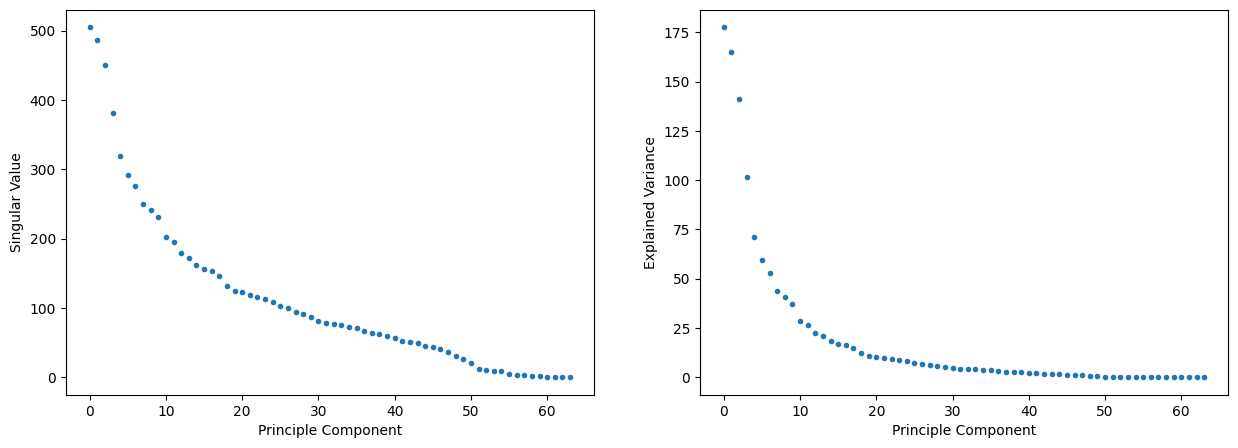

In [35]:
fig, ax = plt.subplots(1,2, figsize = (15, 5))
ax[0].plot(pca.singular_values_, marker='.', linestyle='none')
ax[0].set_xlabel('Principle Component')
ax[0].set_ylabel('Singular Value')

ax[1].plot(pca.explained_variance_, marker='.', linestyle='none')
ax[1].set_xlabel('Principle Component')
ax[1].set_ylabel('Explained Variance')

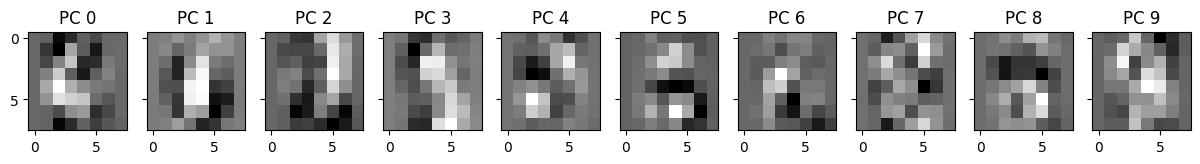

In [36]:
fig, ax = plt.subplots(1,10, figsize = (15,4), sharey=True)

for n in range(10):
    image = refurl_imageset(pca.components_[n], [8,8])
    ax[n].imshow(image, cmap = image_cmap)
    ax[n].set_title(f'PC {n}')
    

TRAINING REPORT:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       153
           1       0.97      0.99      0.98       142
           2       0.95      0.95      0.95       146
           3       0.93      0.93      0.93       150
           4       0.97      0.96      0.97       142
           5       0.98      0.97      0.97       147
           6       0.99      0.99      0.99       141
           7       0.93      0.96      0.95       148
           8       0.92      0.88      0.90       128
           9       0.91      0.94      0.92       140

    accuracy                           0.95      1437
   macro avg       0.95      0.95      0.95      1437
weighted avg       0.95      0.95      0.95      1437

TESTING REPORT:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       0.95      0.97      0.96        40
           2       0.97      1.00      0.98  

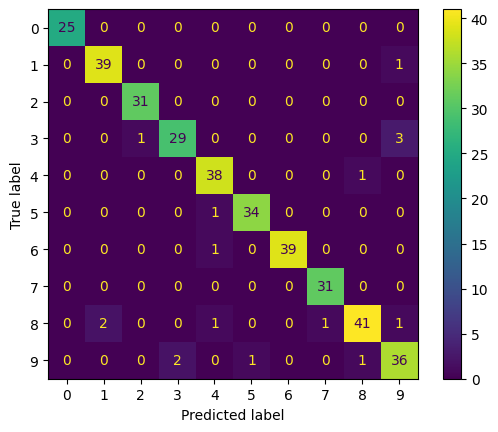

In [41]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

P_train = P_train[:,0:5]
P_test = P_test[:, 0:5]

knn_clf = KNeighborsClassifier(n_neighbors = 3)

knn_clf.fit(P_train, y_train)

y_train_pred = knn_clf.predict(P_train)
y_pred = knn_clf.predict(P_test)

cfm = confusion_matrix(y_true = y_test, y_pred=y_pred)
ConfusionMatrixDisplay(cfm).plot()

print('TRAINING REPORT:')
print(classification_report(y_train, y_train_pred))

print('TESTING REPORT:')
print(classification_report(y_test, y_pred))


What could we try to improve the prediction?